# Project Objective
The aim of this project is to develop a machine learning model that can accurately classify MRI images into four categories related to Alzheimer's disease:
1. Non-Demented
2. Mildly Demented
3. Moderately Demented
4. Severely Demented

To achieve this, the project will explore various data configurations to identify the setup that yields the best performance. Specifically, the following tests will be performed:
* Training the model with training, validation, and test sets without class balancing.
* Training the model with training, validation, and test sets where only the training set is class-balanced.
* Training the model with training, validation, and test sets without class balancing in any of the sets.


## About Alzheimer's Disease:

Alzheimer's disease is a progressive neurological disorder that results in memory loss, cognitive decline, and behavioral changes. 
It is the leading cause of dementia, significantly impairing a person’s ability to think, remember, and perform daily activities. 
Symptoms often begin with mild memory lapses and progressively worsen, affecting language, reasoning, and task execution over time. 
While the exact cause remains unclear, it is believed to be a complex interplay of genetic, environmental, and lifestyle factors. 
Though there is no cure at present, treatments are available to help manage the symptoms.

In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [2]:
print(f'Tensorflow Version: {tf.__version__}')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU Available:", gpus[0])
else:
    print("No GPU Available")

Tensorflow Version: 2.16.1
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Preparation
* **Load dataset**: Import the dataset into environment, making it ready for processing and analysis.
* **Split dataset**: Divide the dataset into training, validation, and test sets to evaluate and fine-tune your model effectively.

In [3]:
TRAIN_PATH = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train"
TEST_PATH  = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test"

IMAGE_SIZE = (176,208)

In [4]:
def get_last_two_tokens(path):
    """Estrae gli ultimi due token dal percorso."""
    parts = path.split(os.path.sep)
    return '/'.join(parts[-2:])

def load_images_from_path(path, label, img_size = IMAGE_SIZE):
    """Carica le immagini da una directory e le etichette associate."""

    num_files = len([f for f in os.listdir(path) if f.endswith('.jpg')])

    for img_file in tqdm(os.listdir(path), desc=f"Loading images from {get_last_two_tokens(path)}", total=num_files):
        try:
            img_path = os.path.join(path, img_file)
            image = load_img(img_path, color_mode='grayscale', target_size=img_size)
            image = img_to_array(image)
            images.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")

classes = [d for d in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, d))]
n_class = len(classes)
images  = []
labels  = []

for label, cls in enumerate(classes):
    cls_train_path = os.path.join(TRAIN_PATH, cls)
    cls_test_path = os.path.join(TEST_PATH, cls)

    load_images_from_path(cls_train_path, label)
    load_images_from_path(cls_test_path, label)

images = np.array(images)
labels = np.array(labels)

print("\nClasses: " + str(classes))
print(f"Total number of images loaded: {len(images)} | Shape: " + str(images.shape))

Loading images from test/MildDemented: 100%|██████████| 179/179 [00:00<00:00, 313.48it/s]



Classes: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
Total number of images loaded: 6400 | Shape: (6400, 176, 208, 1)


When working with data to train a deep learning model, it's essential to split the dataset into multiple parts for specific purposes:

* **Training Set**: This subset of the dataset is used to train the model. The model learns the relationships and patterns from the data in this set.
* **Validation Set**: This set is used to evaluate the model's performance during the training process. It helps to optimize and adjust the model.
* **Test Set**: This set is used to test the final model after it has been trained and optimized. It provides an unbiased evaluation of the model's performance on data that was not used during the training or validation processes.

In [5]:
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

train_size = len(x_train)
valid_size = len(x_val)
test_size  = len(x_test)

total_size = train_size + valid_size + test_size

train_percentage = (train_size / total_size) * 100
valid_percentage = (valid_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

print(f"Train set size: {train_size} ({train_percentage:.2f}%)")
print(f"Validation set size: {valid_size} ({valid_percentage:.2f}%)")
print(f"Test set size: {test_size} ({test_percentage:.2f}%)")

Train set size: 4480 (70.00%)
Validation set size: 960 (15.00%)
Test set size: 960 (15.00%)


# Data augmentation

In this part, we will implement data augmentation techniques to address class imbalance in our MRI image dataset. The aim is to ensure that the training, validation, and test sets are properly balanced to evaluate different model configurations effectively.

**Benefits of Data Augmentation for Balancing**:
* Improved Model Performance: Balancing the training set through augmentation helps the model learn more effectively from all classes, potentially leading to better classification performance, particularly for the minority classes.
* Generalization: By creating a more balanced dataset, the model is less likely to be biased toward majority classes and is better equipped to generalize to new, unseen data.
* Robustness: Data augmentation increases the diversity of the training data, making the model more robust to variations in MRI images and reducing the risk of overfitting.

In [6]:
def plot_class_distribution(train_class_counts, valid_class_counts, test_class_counts, classes, title):
    """
    Plots a grouped bar chart showing the distribution of classes in train, validation, and test sets.
    
    Parameters:
    - train_class_counts: An array of class counts for the training set.
    - valid_class_counts: An array of class counts for the validation set.
    - test_class_counts: An array of class counts for the test set.
    - classes: A list of class name.
    """
    x = np.arange(len(classes))
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_class_counts, width, label='Train Set', color='blue')
    rects2 = ax.bar(x, valid_class_counts, width, label='Validation Set', color='green')
    rects3 = ax.bar(x + width, test_class_counts, width, label='Test Set', color='orange')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2., height,
                    '%d' % int(height), ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)

    plt.tight_layout()
    plt.show()

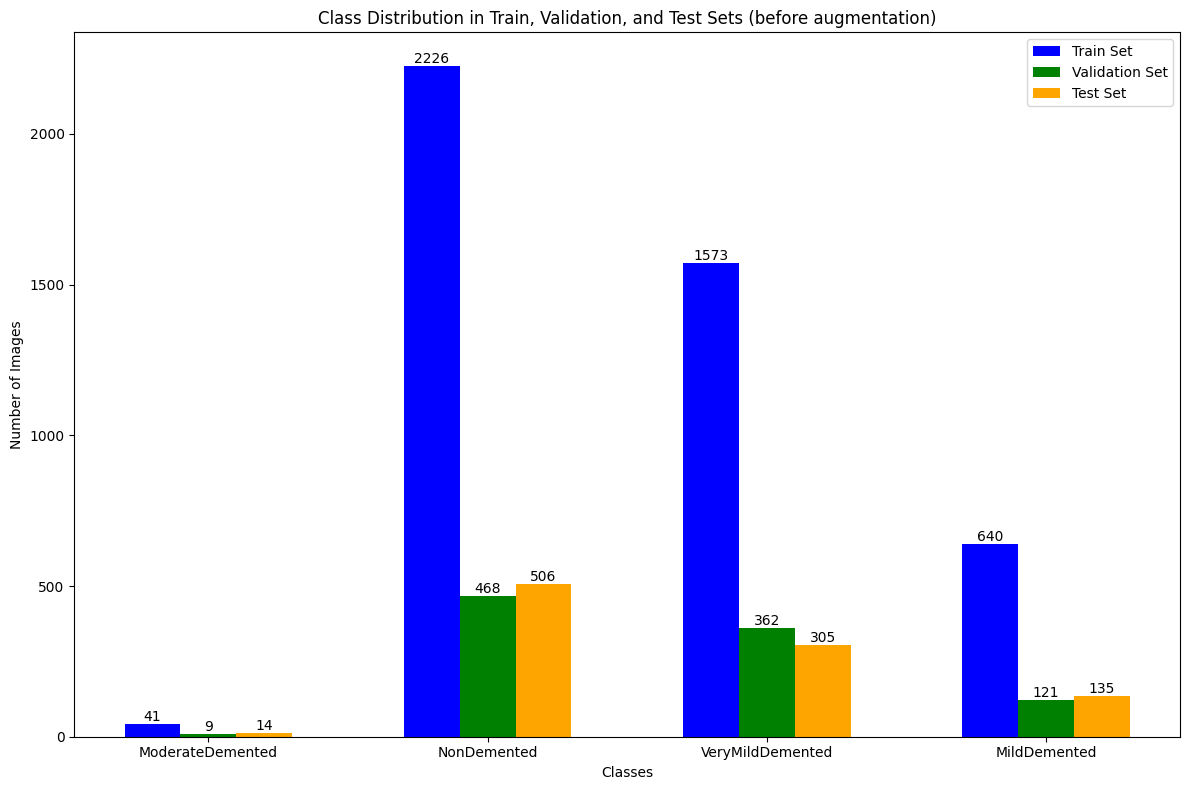

In [7]:
train_class_counts = np.bincount(y_train)
valid_class_counts = np.bincount(y_val)
test_class_counts  = np.bincount(y_test)
plot_class_distribution(train_class_counts, 
                        valid_class_counts, 
                        test_class_counts, 
                        classes,
                        "Class Distribution in Train, Validation, and Test Sets (before augmentation)")

The plotted image of class distribution across the training, validation, and test sets visually represents the number of samples in each class. By examining this plot, you can identify imbalances in the dataset, especially between the "Moderate Demented" and "Non Demented" classes.

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.1, 
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

In [9]:
def balance_dataset(x, y, datagen):
    """
    Balances the dataset by augmenting underrepresented classes to match the number of samples of the most frequent class.

    This function ensures that all classes in the dataset have the same number of samples by using data augmentation 
    techniques. It processes each class separately, augmenting the images of the less frequent classes to equalize 
    the class distributions.

    Parameters:
    - x (numpy.ndarray): The input images as a NumPy array of shape (num_samples, height, width, channels).
    - y (numpy.ndarray): The labels corresponding to the input images as a NumPy array of shape (num_samples,).
    - datagen (ImageDataGenerator): An instance of `ImageDataGenerator`.

    Returns:
    - x_balanced (numpy.ndarray): The balanced dataset of images with augmented samples for underrepresented classes.
    - y_balanced (numpy.ndarray): The balanced dataset of labels corresponding to the augmented images.

    """
    class_counts = Counter(y)
    max_samples = max(class_counts.values())
    
    x_balanced = []
    y_balanced = []
    
    for cls in class_counts:
        class_images = x[y == cls]
        num_original_images = class_images.shape[0]
        
        if num_original_images == max_samples:
            x_balanced.append(class_images)
            y_balanced.append(np.full(num_original_images, cls))
            continue
        
        num_augmented_needed = max_samples - num_original_images
        aug_images = []
        
        for image in class_images:
            image = np.expand_dims(image, 0)
            aug_iter = datagen.flow(image, batch_size=1)
            
            for _ in range(num_augmented_needed):
                augmented_image = next(aug_iter)[0]
                aug_images.append(augmented_image)
                if len(aug_images) >= num_augmented_needed:
                    break
        
        aug_images = np.array(aug_images)[:num_augmented_needed]
        balanced_class_images = np.concatenate((class_images, aug_images), axis=0)
        
        x_balanced.append(balanced_class_images)
        y_balanced.append(np.full(max_samples, cls))
    
    x_balanced = np.concatenate(x_balanced, axis=0)
    y_balanced = np.concatenate(y_balanced, axis=0)
    
    return x_balanced, y_balanced

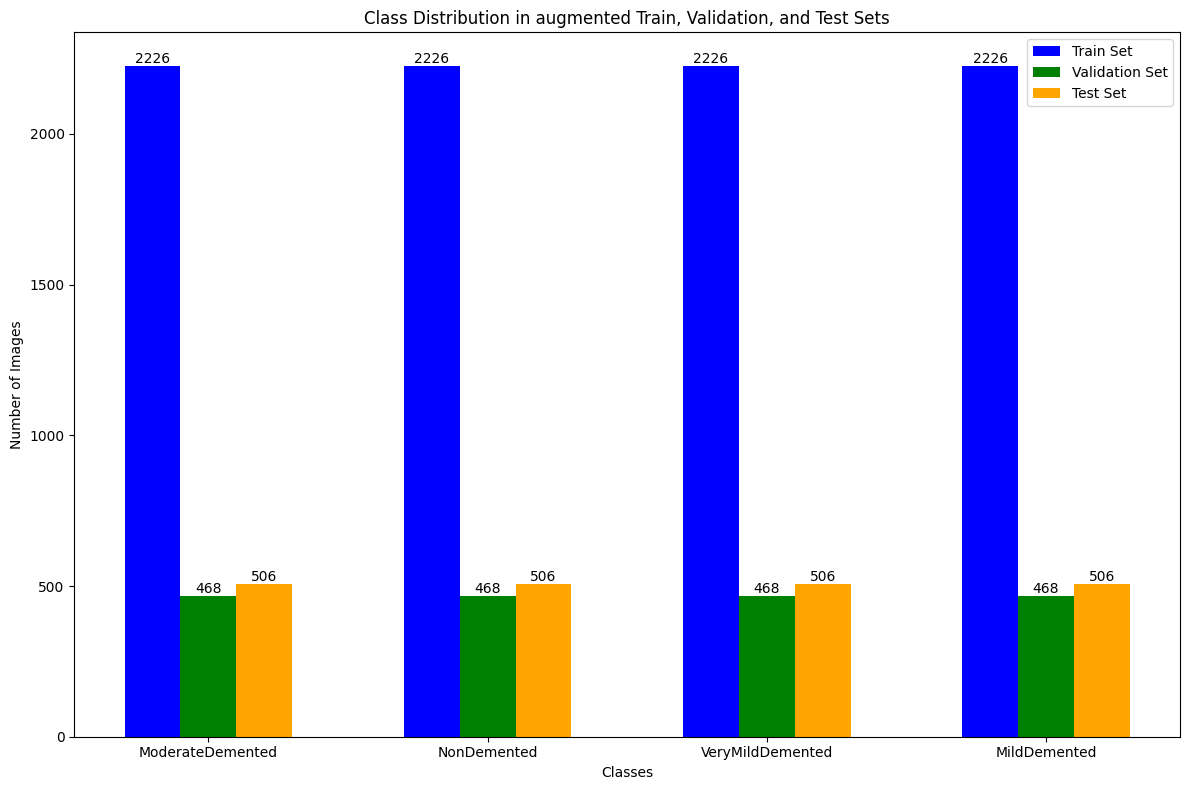

In [10]:
x_train_balanced,y_train_balanced = balance_dataset(x_train, y_train, datagen)
x_val_balanced,y_val_balanced = balance_dataset(x_val, y_val, datagen)
x_test_balanced,y_test_balanced = balance_dataset(x_test, y_test, datagen)

train_agumented_class_counts = np.bincount(y_train_balanced)
valid_agumented_class_counts = np.bincount(y_val_balanced)
test_agumented_class_counts  = np.bincount(y_test_balanced)
plot_class_distribution(train_agumented_class_counts, 
                        valid_agumented_class_counts, 
                        test_agumented_class_counts, 
                        classes,
                        "Class Distribution in augmented Train, Validation, and Test Sets")

# Data normalization

This section of the code performs the following tasks: 

* **Data Normalization**: Categorical Encoding: Converts class labels for training, validation, and test datasets into one-hot encoded format using to_categorical. This step prepares the labels for classification tasks where each class is represented as a binary vector.
* **Image Rescaling**: Applies normalization to image data using ImageDataGenerator from Keras, which rescales pixel values ​​to the range [0, 1] by dividing by 255. This ensures that the input data to the model is in a standardized range.
* **Generator Creation**: Creates data generators using ImageDataGenerator.flow for training, validation, and test datasets. The generators shuffle the training and validation data, while the test data is not shuffled. This allows for efficient data handling and augmentation during model training.

In [11]:
def printGeneratorInfo(generator, generator_name):
    """
    Function to count the total number of samples in a generator by iterating through all batches.

    Parameters:
    generator: The data generator to iterate through.
    generator_name: Name of the generator for display purposes.

    Returns:
    total_samples: The total number of samples in the generator.
    """
    total_samples = 0
    batch_count = 0
    
    # Loop through the generator to count all samples in each batch
    for batch_x, batch_y in generator:
        batch_size = batch_x.shape[0]
        total_samples += batch_size
        batch_count += 1
        
        # Stop when all data is processed, based on generator's total sample count
        if total_samples >= generator.n:
            break

    # Reset the generator state
    generator.reset()

    print(f"{generator_name} - Total samples: {total_samples} (Processed in {batch_count} batches)")

In [12]:
y_train_balanced = to_categorical(y_train_balanced, num_classes=n_class)
y_val_balanced = to_categorical(y_val_balanced, num_classes=n_class)
y_test_balanced = to_categorical(y_test_balanced, num_classes=n_class)

y_train = to_categorical(y_train, num_classes=n_class)
y_val = to_categorical(y_val, num_classes=n_class)
y_test = to_categorical(y_test, num_classes=n_class)

In [102]:
normalDatagen = ImageDataGenerator(rescale=1./255)

train_augmented_generator = normalDatagen.flow(x_train_balanced, y_train_balanced, shuffle=True)
val_augmented_generator = normalDatagen.flow(x_val_balanced, y_val_balanced, shuffle=True)
test_augmented_generator = normalDatagen.flow(x_test_balanced, y_test_balanced, shuffle=False)

train_generator = normalDatagen.flow(x_train, y_train, shuffle=True)
val_generator = normalDatagen.flow(x_val, y_val, shuffle=True)
test_generator = normalDatagen.flow(x_test, y_test, shuffle=False)

printGeneratorInfo(train_augmented_generator, "train_augmented_generator")
printGeneratorInfo(val_augmented_generator, "val_augmented_generator")
printGeneratorInfo(test_augmented_generator, "test_augmented_generator")

printGeneratorInfo(train_generator, "train_generator")
printGeneratorInfo(val_generator, "val_generator")
printGeneratorInfo(test_generator, "test_generator")

train_augmented_generator - Total samples: 8904 (Processed in 279 batches)
val_augmented_generator - Total samples: 1872 (Processed in 59 batches)
test_augmented_generator - Total samples: 2024 (Processed in 64 batches)
train_generator - Total samples: 4480 (Processed in 140 batches)
val_generator - Total samples: 960 (Processed in 30 batches)
test_generator - Total samples: 960 (Processed in 30 batches)


# Data visualization

In [14]:
def collect_and_display_images(generator, classes, num_images_per_class=5, plotTitle="Plot"):
    """
    Function to collect and display images from the validation generator, organized by class.

    Parameters:
    generator (generator): Generator that yields image batches and corresponding labels.
    classes (list): List of class names.
    num_images_per_class (int): Number of images to collect for each class.
    plotTitle (str): Title of the plot.

    Returns:
    None: Displays a plot of images collected.
    """
    
    unique_classes = list(set(classes))
    n_class = len(unique_classes)

    class_images = {i: [] for i in range(n_class)}
    images_collected = {i: 0 for i in range(n_class)}

    # Extract images from the generator
    for batch_x, batch_y in generator:
        for img, label in zip(batch_x, np.argmax(batch_y, axis=1)):
            # Add image to the class if the quota is not reached
            if images_collected[label] < num_images_per_class:
                class_images[label].append(img)
                images_collected[label] += 1

            # Stop if we have enough images for all classes
            if all(count >= num_images_per_class for count in images_collected.values()):
                break
        if all(count >= num_images_per_class for count in images_collected.values()):
            break

    fig, axes = plt.subplots(n_class, num_images_per_class, figsize=(num_images_per_class * 3, n_class * 3))
    fig.suptitle(plotTitle, fontsize=32)

    for class_idx, images in class_images.items():
        for i, img in enumerate(images):
            ax = axes[class_idx, i]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Class: {classes[class_idx]}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

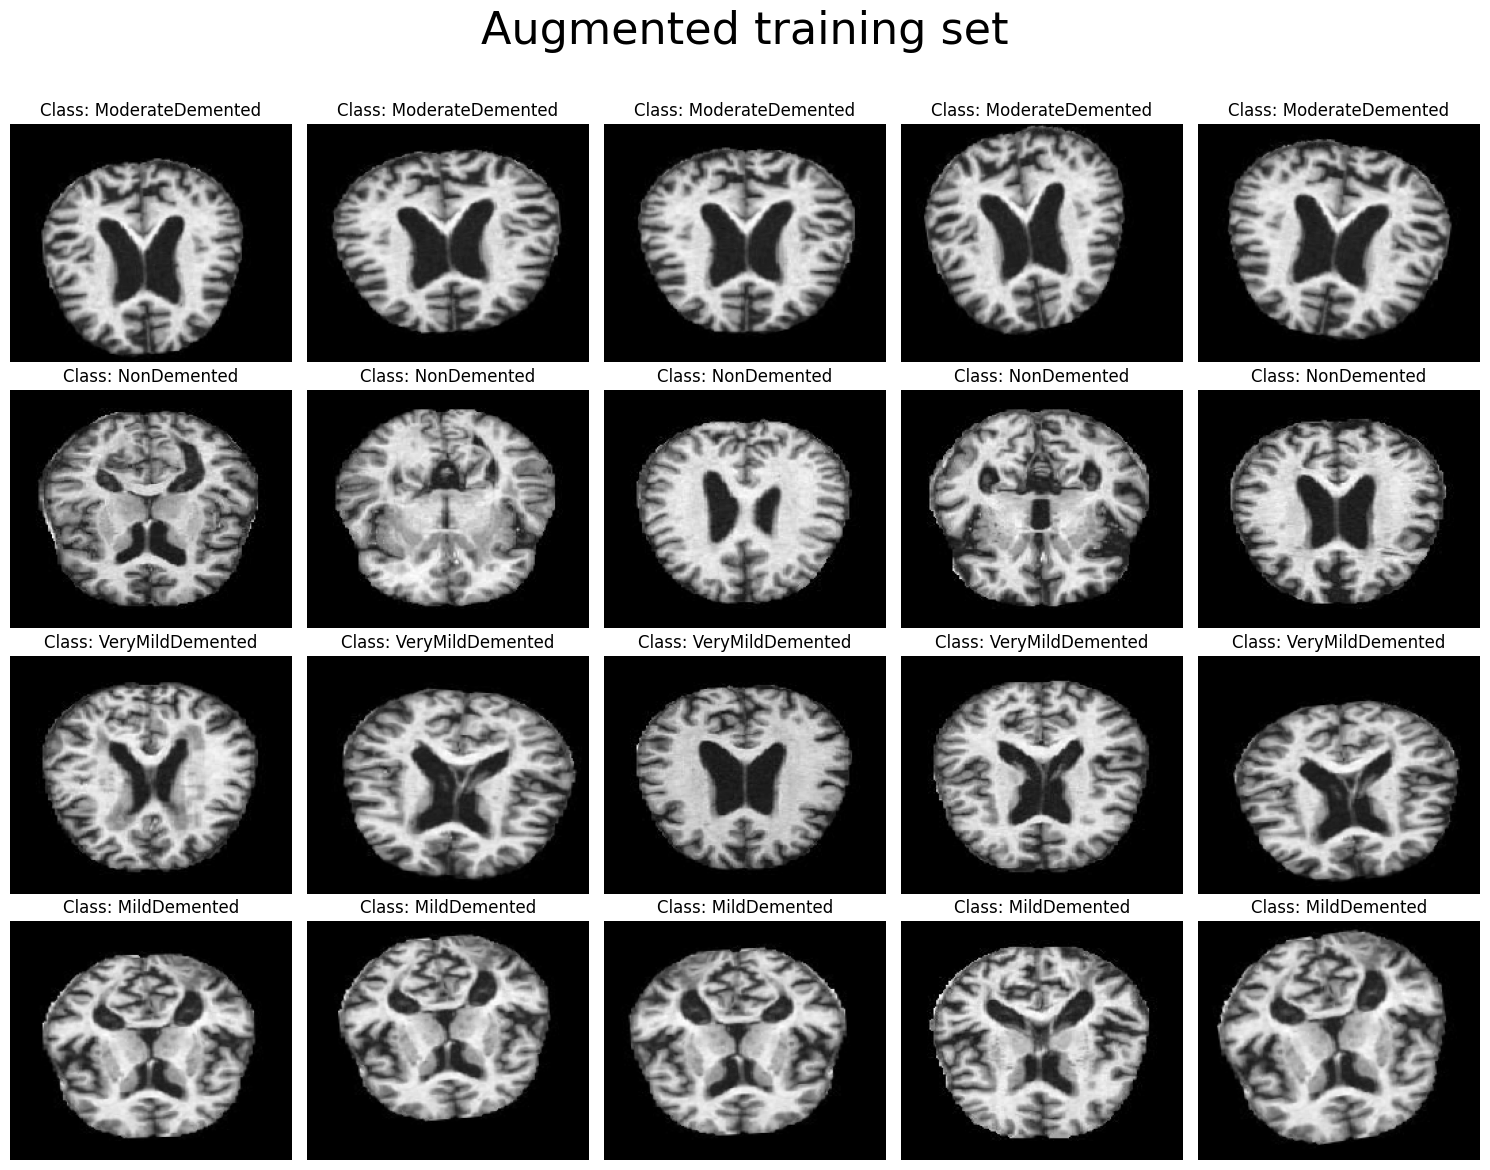

In [15]:
collect_and_display_images(train_augemntad_generator, classes, plotTitle="Augmented training set")

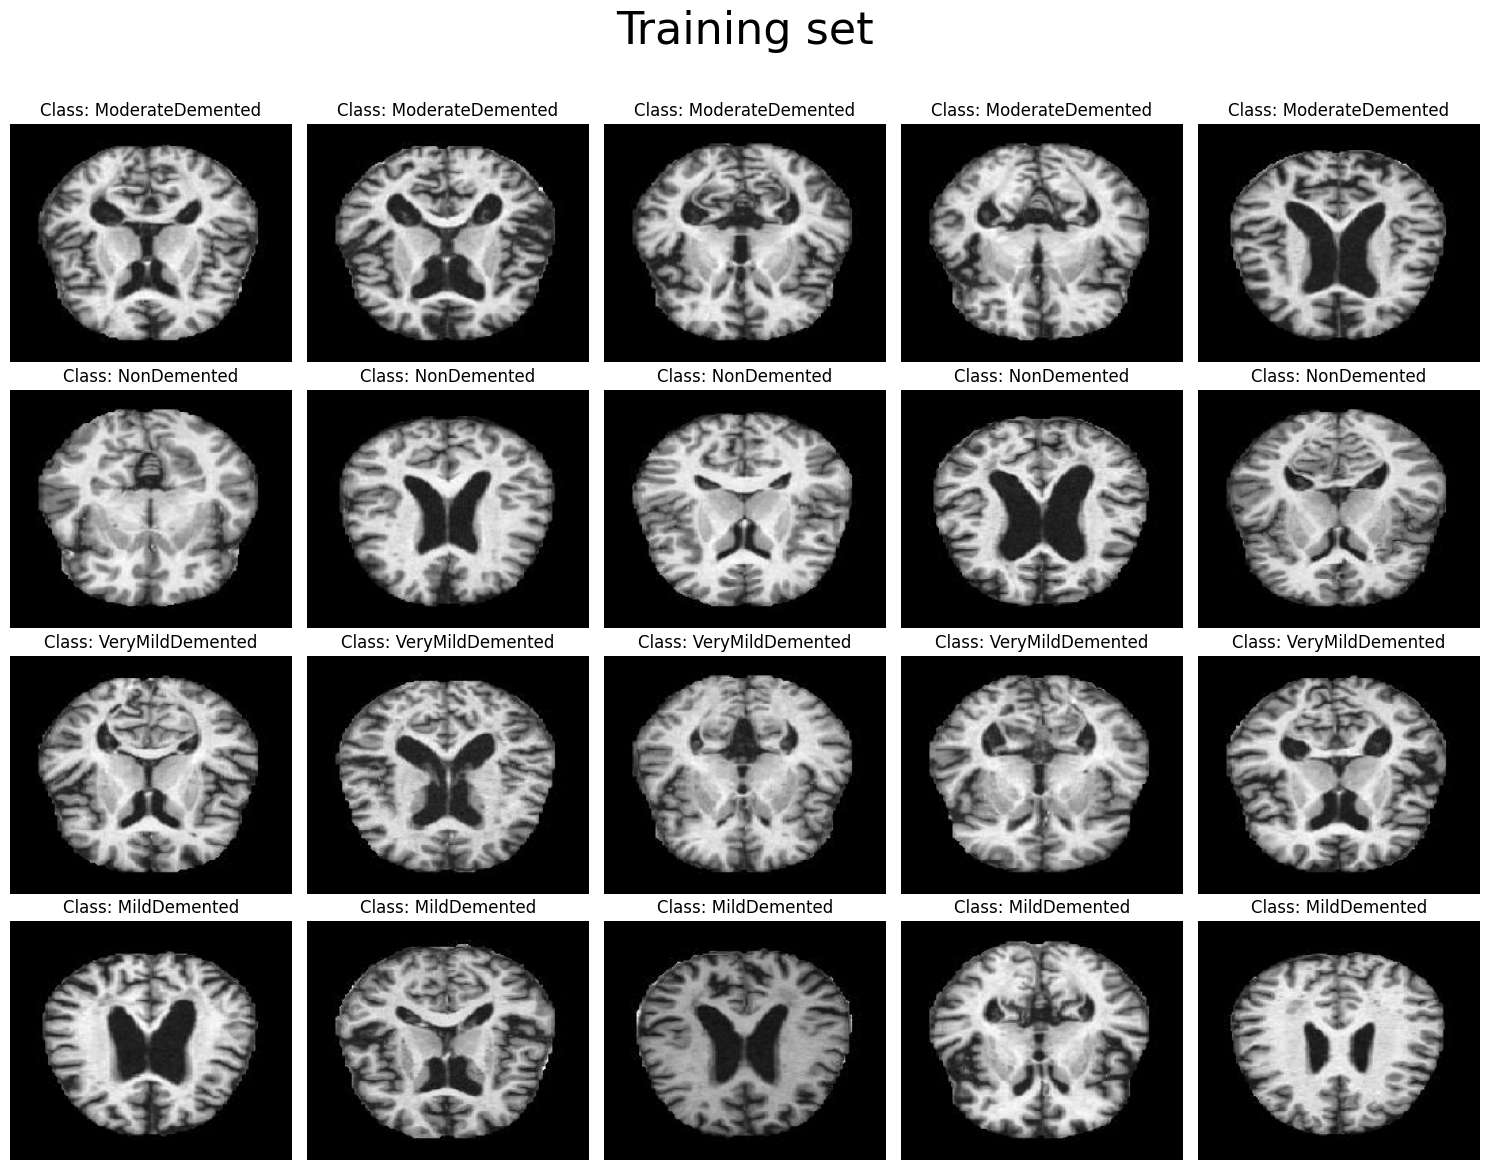

In [16]:
collect_and_display_images(train_generator, classes, plotTitle="Training set")

# Training

In [98]:
class CNN:
    def __init__(self, input_shape, classes, train_generator, val_generator, test_generator):
        self.input_shape = input_shape
        self.num_classes = len(classes)
        self.classes = classes
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.test_generator = test_generator
        self.model = self.__create_model()
        
    def __create_model(self):
        model = Sequential()

        # First convolutional block
        model.add(Input(shape=(176, 208, 1)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Second convolutional block
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Third convolutional block
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Flattening the feature maps
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        return model
    
    def compile_model(self, learning_rate):
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
    def fit_model(self, epochs=25):
        model_checkpoint = ModelCheckpoint(
            filepath='best_model_{val_accuracy:.2f}.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=False
        )
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        callbacks = [early_stopping, model_checkpoint]

        history = self.model.fit(
            self.train_generator,
            epochs=epochs,
            validation_data=self.val_generator,
            callbacks=callbacks
        )
        return history
    
    def evaluate_model(self):
        test_loss, test_accuracy = self.model.evaluate(self.test_generator)
        test_accuracy_percentage = test_accuracy * 100
        print(f'Test Loss: {test_loss:.4f}')
        print(f'Test Accuracy: {test_accuracy_percentage:.2f}%')

    def predict_report(self):
        y_pred = self.model.predict(self.test_generator)
        
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(self.test_generator.y, axis=1) 
        
        print("\nClassification Report:")
        print(classification_report(y_true_classes, y_pred_classes, target_names=self.classes))
    
    
def plot_history(model_history):
    fig, ax = plt.subplots(2, 1, figsize=(10, 15))

    ax[0].plot(model_history.history['accuracy'], label='Train Accuracy', color='blue')
    ax[0].plot(model_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(model_history.history['loss'], label='Train Loss', color='blue')
    ax[1].plot(model_history.history['val_loss'], label='Validation Loss', color='orange')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

## Case 1 : Simple training

In [99]:
cnnWA = CNN(input_shape=(176, 208, 1), 
            classes=classes, 
            train_generator=train_generator, 
            val_generator=val_generator, 
            test_generator=test_generator)

cnnWA.compile_model(learning_rate=1e-4)

In [85]:
cnnWA_history = cnnWA.fit_model(epochs=25)
cnnWA.evaluate_model()

Epoch 1/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4744 - loss: 1.0597 - val_accuracy: 0.5010 - val_loss: 0.9413
Epoch 2/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5474 - loss: 0.9232 - val_accuracy: 0.5771 - val_loss: 0.8643
Epoch 3/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6180 - loss: 0.8433 - val_accuracy: 0.6219 - val_loss: 0.8298
Epoch 4/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6387 - loss: 0.7877 - val_accuracy: 0.6604 - val_loss: 0.7478
Epoch 5/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7154 - loss: 0.6785 - val_accuracy: 0.7198 - val_loss: 0.6601
Epoch 6/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7506 - loss: 0.6124 - val_accuracy: 0.7583 - val_loss: 0.5841
Epoch 7/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7777 - loss: 0.5431 - val_accuracy: 0.7698 - val_loss: 0.5508
Epoch 8/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8310 - loss: 0.4414 - val_accu

In [100]:
cnnWA.predict_report()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
                  precision    recall  f1-score   support

ModerateDemented       0.00      0.00      0.00        14
     NonDemented       0.53      0.94      0.68       506
VeryMildDemented       0.00      0.00      0.00       305
    MildDemented       0.15      0.07      0.09       135

        accuracy                           0.51       960
       macro avg       0.17      0.25      0.19       960
    weighted avg       0.30      0.51      0.37       960



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


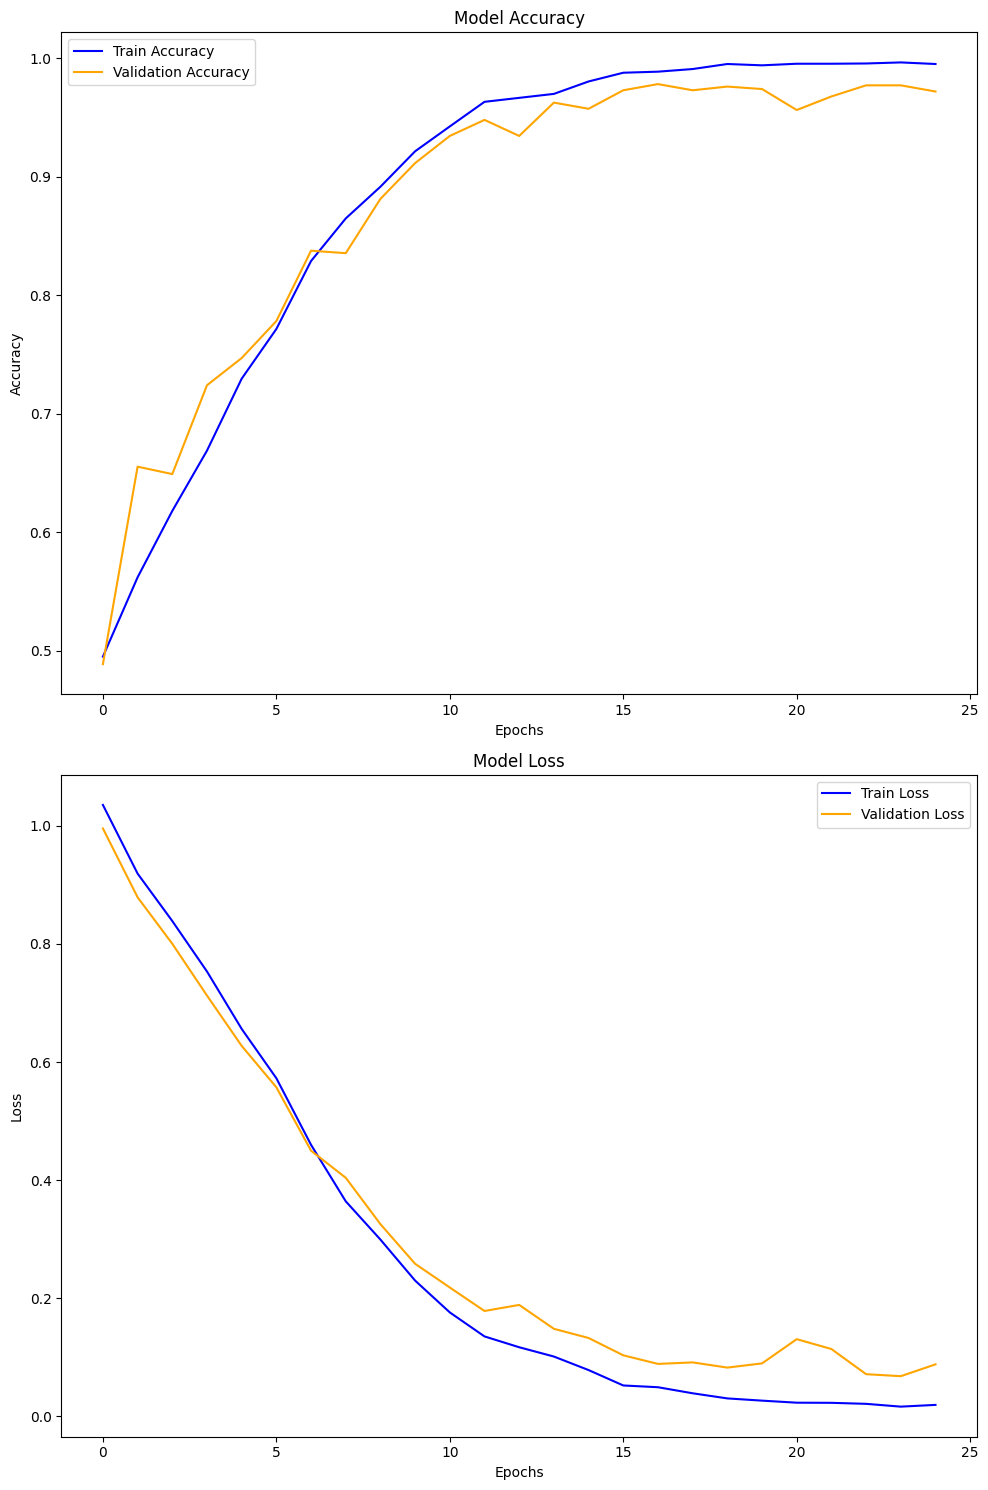

In [81]:
plot_history(cnnWA_history)

## Case 2 : Training with train set augmented

In [103]:
cnnTA = CNN(input_shape=(176, 208, 1), 
            classes=classes, 
            train_generator=train_augmented_generator, 
            val_generator=val_generator, 
            test_generator=test_generator)

cnnTA.compile_model(learning_rate=1e-4)

In [104]:
cnnTA_history = cnnTA.fit_model(epochs=25)
cnnTA.evaluate_model()

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


279/279 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6035 - loss: 0.9414 - val_accuracy: 0.6031 - val_loss: 0.8870
Epoch 2/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7954 - loss: 0.4627 - val_accuracy: 0.6292 - val_loss: 0.8153
Epoch 3/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8152 - loss: 0.4135 - val_accuracy: 0.6844 - val_loss: 0.7140
Epoch 4/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8435 - loss: 0.3573 - val_accuracy: 0.6760 - val_loss: 0.6931
Epoch 5/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8782 - loss: 0.2942 - val_accuracy: 0.7781 - val_loss: 0.5310
Epoch 6/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9060 - loss: 0.2385 - val_accuracy: 0.7885 - val_loss: 0.4819
Epoch 7/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9268 - loss: 0.1854 - val_accuracy: 0.8906 - val_loss: 0.3272
Epoch 8/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9517 - loss: 0.1373 - val_accuracy: 0.88

In [105]:
cnnTA.predict_report()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
                  precision    recall  f1-score   support

ModerateDemented       1.00      1.00      1.00        14
     NonDemented       0.98      0.99      0.99       506
VeryMildDemented       0.99      0.97      0.98       305
    MildDemented       0.97      0.97      0.97       135

        accuracy                           0.98       960
       macro avg       0.99      0.98      0.98       960
    weighted avg       0.98      0.98      0.98       960



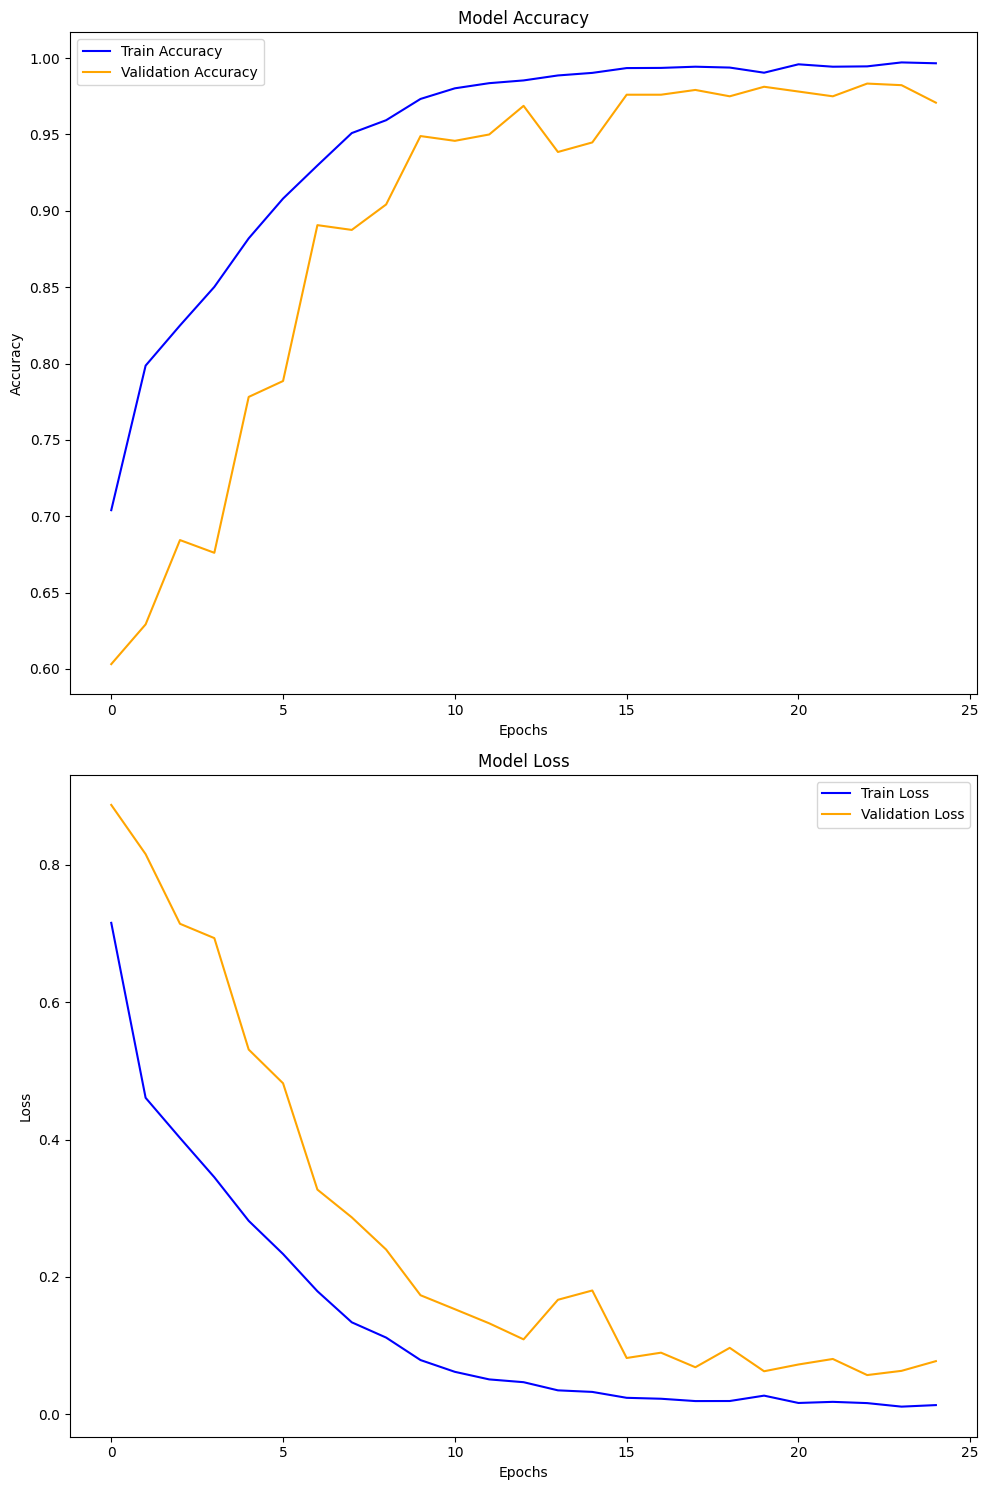

In [107]:
plot_history(cnnTA_history)

## Case 3 : Training with all set augmented

In [114]:
cnnAA = CNN(input_shape=(176, 208, 1), 
            classes=classes, 
            train_generator=train_augmented_generator, 
            val_generator=val_augmented_generator, 
            test_generator=test_augmented_generator)

cnnAA.compile_model(learning_rate=1e-4)

In [115]:
cnnAA_history = cnnAA.fit_model(epochs=25)
cnnAA.evaluate_model()

Epoch 1/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.5916 - loss: 0.9432 - val_accuracy: 0.4033 - val_loss: 1.4018
Epoch 2/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7859 - loss: 0.4927 - val_accuracy: 0.4439 - val_loss: 1.7830
Epoch 3/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8187 - loss: 0.4105 - val_accuracy: 0.5064 - val_loss: 1.4420
Epoch 4/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8442 - loss: 0.3594 - val_accuracy: 0.5913 - val_loss: 1.8462
Epoch 5/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8791 - loss: 0.2881 - val_accuracy: 0.6084 - val_loss: 1.6905
Epoch 6/25
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9104 - loss: 0.2305 - val_accuracy: 0.6138 - val_loss: 1.9662
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5927 - loss: 1.0553
Test Loss: 2.0714
Test Accuracy: 28.61%


In [116]:
cnnAA.predict_report()

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
                  precision    recall  f1-score   support

ModerateDemented       0.01      0.00      0.00       506
     NonDemented       0.60      0.92      0.73       506
VeryMildDemented       0.24      0.20      0.22       506
    MildDemented       0.02      0.02      0.02       506

        accuracy                           0.29      2024
       macro avg       0.22      0.29      0.24      2024
    weighted avg       0.22      0.29      0.24      2024



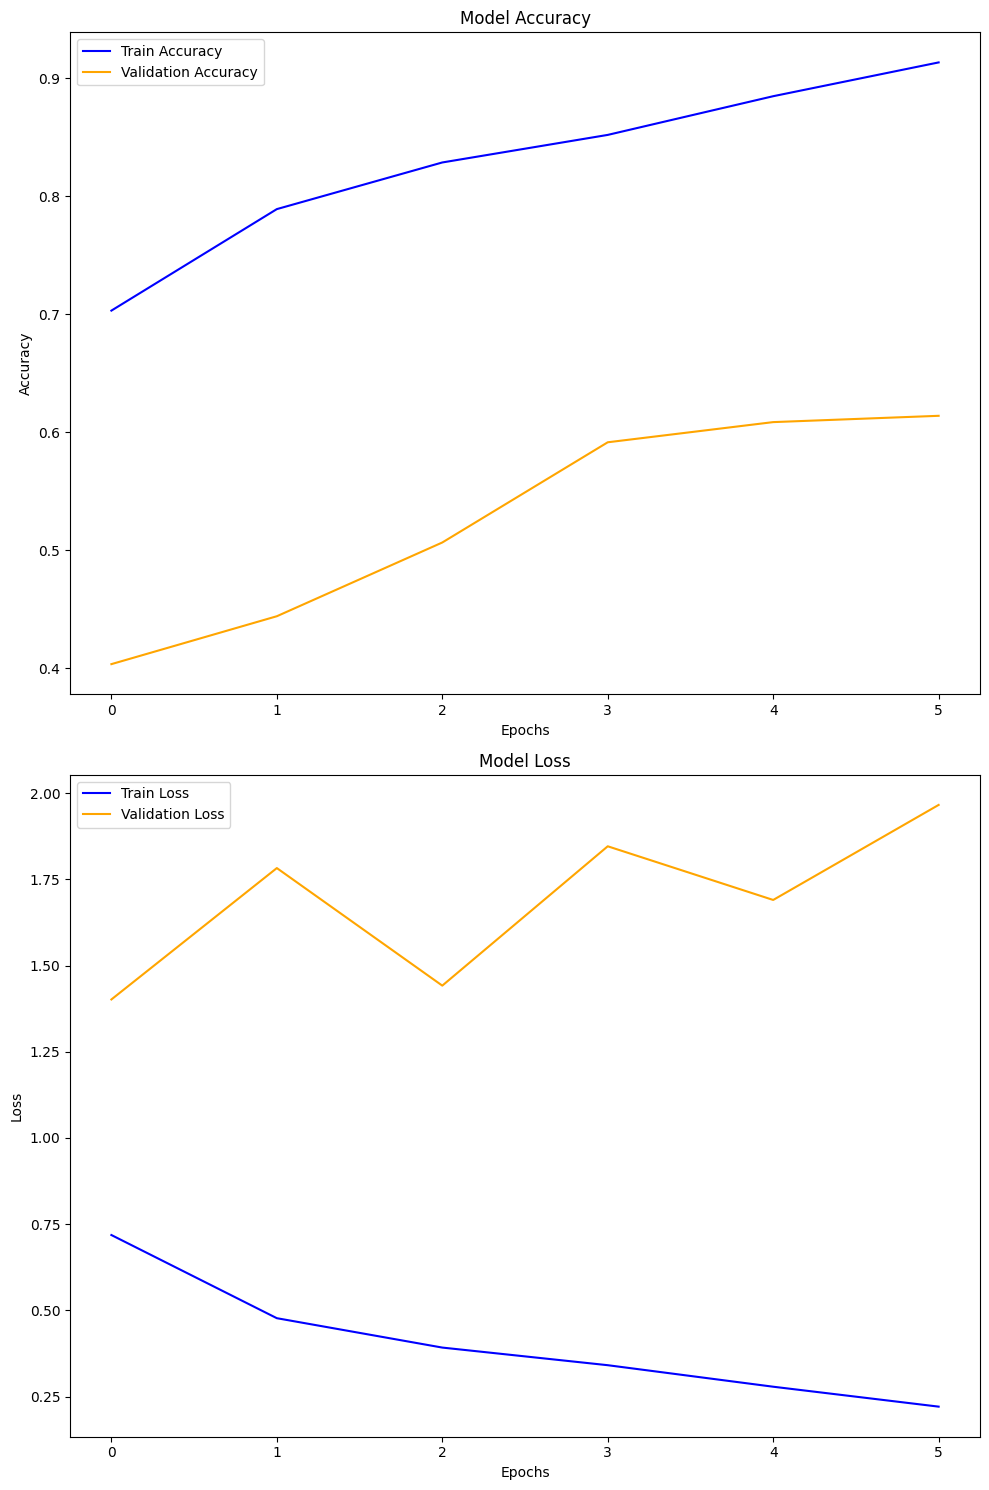

In [117]:
plot_history(cnnAA_history)